# Simplified gas dispersion example

- From the data you shared, I'm comparing the receptors data with the optimal solution you found.
- This is limited, but I would expect this to roughly align.
- Two approaches:
    - Simplified example
    - Overall fitness

In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import numpy as np
np.set_printoptions(threshold=np.inf)
np.set_printoptions(linewidth=np.inf)
np.set_printoptions(suppress = True)

import os
import matplotlib.pyplot as plt

import gas_dispersion as gas
from utils import *

DATA = '/home/leonardo/Dropbox/Work/WB/Promoged/data/ipm/'

## Load data

- Converted the data you shared in CSVs

Sources:

In [2]:
# Optimal solution found by Nizar
sources_df = pd.read_csv(os.path.join(os.path.join(DATA, 'belhadjali_solution.csv')))
sources_df.head()

,lat,lon,Q
0,33.17668,-84.85035,2.93000
1,33.17635,-84.84619,1.19000
2,33.17376,-84.84680,0.33600
3,33.17670,-84.85017,2.77700
4,33.17418,-84.84746,1.32700


Receptors:

In [3]:
receptors_df =  pd.read_csv(os.path.join(DATA, 'belhadjali_dem.csv'))
receptors_df.head()

,lat,lon,ch4_ppm,wind_speed_mph,wind_dir
0,33.17880,-84.84681,23,5.62000,298
1,33.17373,-84.84712,22,7.96000,317
2,33.17373,-84.84711,24,7.96000,317
3,33.17372,-84.84710,27,7.79000,321
4,33.17371,-84.84706,29,7.68000,325


**Source receptor config:**

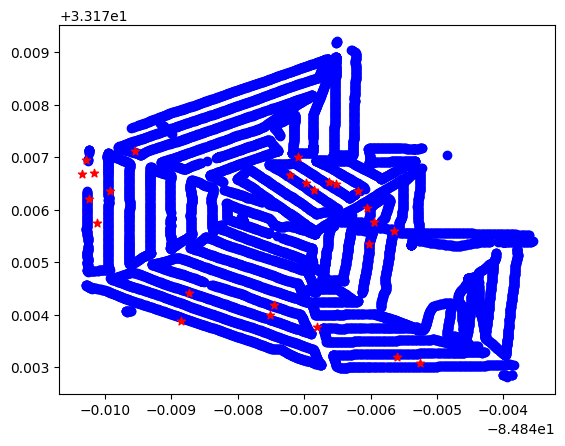

In [4]:
fig, ax = plt.subplots()
ax.scatter(receptors_df['lon'], receptors_df['lat'], c ="blue")
ax.scatter(sources_df['lon'], sources_df['lat'], c ="red", marker ="*")

# ax.scatter(opt, source[0], )

## Process receptors data 

Reproject to UTM:
- https://epsg.io/32617

In [5]:
receptors_df = utm_coordinates(receptors_df, 32617)

PPM to $\mu g/s$ conversion: 

Calculators:
 - https://www.gastec.co.jp/en/technology/knowledge/concentration/
 - https://www.lenntech.com/calculators/ppm/converter-parts-per-million.html
 - https://www.gasdetection.com/calculator/ppm_to_micrograms_per_cubic_meter.html

Bel Hadj Ali's code:
```
convertppm = Pressure*16.04/(273.15+Temperature)/8.3144621;
Data(:,3)= convertppm*Data(:,3);
```

In [6]:
def ppm_to_mugm3_original(ppm, pressure = 1, temperature = 25):    
    return ppm*(pressure*16.04/(273.15+temperature)/8.3144621)*1000

# Simplified version 
def ppm_to_mugm3(ppm):
    """
    https://teesing.com/en/library/tools/ppm-mg3-converter
    """
    mgs = 0.0409*ppm*16.04
    return mgs*1000

receptors_df['ch4_mugm3'] = ppm_to_mugm3_original(receptors_df['ch4_ppm'])

In [7]:
pd.concat([receptors_df[['ch4_ppm']], ppm_to_mugm3_original(receptors_df[['ch4_ppm']].reset_index(drop=True)), ppm_to_mugm3(receptors_df[['ch4_ppm']])], axis = 1).head()

,ch4_ppm,ch4_ppm,ch4_ppm
0,23,148.82066,15088.82800
1,22,142.35020,14432.79200
2,24,155.29112,15744.86400
3,27,174.70251,17712.97200
4,29,187.64344,19025.04400


Wind speed from mph to m/s:

In [8]:
def mph_to_ms(speed):
    return 0.44704*speed

receptors_df['wind_speed_ms'] = mph_to_ms(receptors_df['wind_speed_mph'])

Set altitude to zero since this is surface emissions monitoring:

In [9]:
receptors_df['altitude'] = 0

**Check if it looks OK:**

In [10]:
receptors_df.head()

,lat,lon,ch4_ppm,wind_speed_mph,wind_dir,lat_utm,lon_utm,ch4_mugm3,wind_speed_ms,altitude
0,33.17880,-84.84681,23,5.62000,298,3677705.68047,141264.81122,148.82066,2.51236,0
1,33.17373,-84.84712,22,7.96000,317,3677143.77224,141214.90627,142.35020,3.55844,0
2,33.17373,-84.84711,24,7.96000,317,3677143.32327,141215.60272,155.29112,3.55844,0
3,33.17372,-84.84710,27,7.79000,321,3677142.84698,141217.01115,174.70251,3.48244,0
4,33.17371,-84.84706,29,7.68000,325,3677141.02271,141220.50796,187.64344,3.43327,0


## Process sources data 

Reproject to UTM:
- https://epsg.io/32617

In [11]:
sources_df = utm_coordinates(sources_df, 32617)

Covnert from $g/s$ to $\mu g/s$:

In [12]:
unit_converstion_factor = 10e6
sources_df['Q_mugm3'] = sources_df['Q']*unit_converstion_factor

In [13]:
sources_df.head()

,lat,lon,Q,lat_utm,lon_utm,Q_mugm3
0,33.17668,-84.85035,2.93000,3677482.32274,140925.75571,29300000.00000
1,33.17635,-84.84619,1.19000,3677431.41537,141312.59536,11900000.00000
2,33.17376,-84.84680,0.33600,3677146.11252,141245.09896,3360000.00000
3,33.17670,-84.85017,2.77700,3677483.92342,140942.63401,27770000.00000
4,33.17418,-84.84746,1.32700,3677194.98374,141185.22465,13270000.00000


## Simplify data
- Restrict to a 5 sources and 2 receptors 
- Reason to believe these are the only sources relevant for these receptors

In [14]:
sources_list = [16,4,17,9,5]
receptors_list = [4, 27]

In [15]:
sources_df_smp = sources_df[["lat_utm", "lon_utm", "Q_mugm3"]]
sources_df_smp = sources_df_smp.iloc[sources_list]
sources = sources_df_smp.to_numpy()
# sources
sources_df_smp

,lat_utm,lon_utm,Q_mugm3
16,3677174.10659,141178.84977,24460000.00000
4,3677194.98374,141185.22465,13270000.00000
17,3677224.86748,141067.65182,1960000.00000
9,3677166.46865,141054.28881,19940000.00000
5,3677377.22583,140943.37665,21090000.00000


In [16]:
receptors_df_smp = receptors_df[['lat_utm', 'lon_utm', 'altitude', 'wind_speed_ms', 'wind_dir', 'ch4_mugm3']]
receptors_df_smp = receptors_df_smp.iloc[receptors_list]
receptors = receptors_df_smp.to_numpy()
# receptors
receptors_df_smp

,lat_utm,lon_utm,altitude,wind_speed_ms,wind_dir,ch4_mugm3
4,3677141.02271,141220.50796,0,3.43327,325,187.64344
27,3677133.27767,141235.19452,0,3.66573,322,51.76371


Config

In [17]:
%%html
<div class="row">
  <div class="column">
    <img src="img/winddir.png" alt="Snow" style="float: left; width: 150px">
  </div>
  <div class="column">
    <img src="img/config-zout2.png" alt="Snow" style="float: left; width: 500px">
  </div>
  <div class="column">
    <img src="img/config-zin2.png" alt="Snow" style="float: right; width: 500px">
  </div>
</div>

## Gas dispersion model -  Single source (16)
- How a single source (closest) affects both receptors.

Model parameters

In [18]:
source = sources[0]
wind_speed = receptors[:,3]
wind_dir = receptors[:,4]
receptors_coords = receptors[:,0:2]
source_coordinates = source[0:2]

Calculate distance between points:

In [19]:
distances = gas.eucl_dist(receptors_coords, source_coordinates) # OK
distances

array([53.19725027, 69.58255176])

Angle with the wind:

In [20]:
up = gas.up_wind_point(receptors, True)
beta = gas.calc_angle(receptors_coords, source_coordinates, up)
beta


array([16.54428826, 16.07190193])

Along and across wind distances:

In [21]:
x,y = gas.calc_wind_distances(distances, beta, wind_dir)
z = receptors[:,2]
x,y,z

(array([50.99487939, 66.86292014]),
 array([15.14825771, 19.2634737 ]),
 array([0., 0.]))

Dispersion model:
- Using stability class A for simplicity.
- Tried all of the other ones multiple times.

In [22]:
def dispersion_model(x, y, z, source, wind_speed, stability_cass = 'A'):

    H = 0.
    
    # Wind speed
    u = wind_speed.copy()
    
    # Source emissions
    Q = source[-1]

    if stability_cass == 'A':
        sy = 0.22*x*(1+0.0001*x)**(-.5)
        sz = 0.2*x
    elif stability_cass == 'B':
        sy = 0.16*x*(1+0.0001*x)**(-.5)
        sz = 0.12*x
    elif stability_cass == 'C':
        sy = 0.11*x*(1+0.0001*x)**(-.5)
        sz = 0.08*x*(1+0.0002*x)**(-.5)
    elif stability_cass == 'D':
        sy = 0.08*x*(1+0.0001*x)**(-.5)
        sz = 0.06*x*(1+0.0015*x)**(-.5)
        
    # C = (Q/(math.pi*u*sy*sz)) * math.exp((-1/2)*(y/sy**2))
    C = (Q/(2*math.pi*u*sy*sz)) * np.exp((-1/2)*(y**2/sy**2)) *(
         np.exp((-1/2)*((z-H)**2)/sz) +
         np.exp((-1/2)*((z+H)**2)/sz) 
        ) 
    
    # return C.reshape(len(C),1)
    return C

In [23]:
dispersion_model(x, y, z, source, wind_speed, 'A')

array([7948.45582998, 4569.64002668])

## Gas dispersion model -  All sources
- Do the exact same process in a loop

In [24]:
def receptor_source_loop(receptors, sources, stability_cass = 'A', era_standard = True):
    wind_speed = receptors[:,3]
    wind_dir = receptors[:,4]
    receptors_coords = receptors[:,0:2]
    
    c_pred_matrix = []
    for source in sources:
        # print(f'Source: {source}')
        source_coordinates = source[0:2]
        
        # Euclidian distance or Hypotenuse
        distances = gas.eucl_dist(receptors_coords, source_coordinates)
        
        # Line slope angle
        upwind_pt = gas.up_wind_point(receptors, era_standard)
        beta = gas.calc_angle(receptors_coords, source_coordinates, upwind_pt)
        
        # Distances relative to the wind
        x,y = gas.calc_wind_distances(distances, beta, wind_dir)
        z = receptors[:,2]
        
        cj = dispersion_model(x, y, z, source, wind_speed, stability_cass)
        # c_pred_matrix = np.concatenate((c_pred_matrix,[cj]),axis=0)
        c_pred_matrix.append(cj)
        
    # return np.stack(c_pred_matrix, axis=1)
    return c_pred_matrix


In [25]:
concentrations_df = pd.DataFrame(receptor_source_loop(receptors, sources), 
                                 columns = [str(i) for i in receptors_list], 
                                 index = sources_list)
concentrations_df

,4,27
16,7948.45583,4569.64003
4,6684.70887,4158.32609
17,13.25920,17.94415
9,0.03365,0.54332
5,176.94522,187.20982


## Concentration disparity (???)

In [26]:
concentrations_df.sum()

4    14823.40277
27    8933.66340
dtype: float64

In [27]:
receptors_df_smp[['ch4_mugm3']]

,ch4_mugm3
4,187.64344
27,51.76371


## Fitness function

In [28]:
observed = receptors_df[['ch4_mugm3']].to_numpy()
# observed

In [45]:
# observed = receptors[:,-1]
    
def fitness_function(solution, solution_index, stability_cass = 'A', era_standard = True):
    
    sources_array = np.reshape(solution, (-1, 3))
    
    # Gas dispersion model simulation
    predicted = gas.gas_concentration_predict(receptors, sources_array, stability_cass, era_standard)
    
    # fitness = 1.0/(((predicted - observed)**2).sum()/(observed**2).sum())
    # fitness = 1.0/(((predicted - observed)**2).sum())
    fitness =  np.linalg.norm(predicted - observed)/np.linalg.norm(observed)
    return fitness

Use for full solution

In [46]:
solution = sources_df[["lat_utm", "lon_utm", "Q_mugm3"]].to_numpy()
fitness_function(solution, 1)

34.9066819005335